## Variabili Categoriche
Una **variabile categorica** assume solo un numero limitato di valori.

Consideriamo un sondaggio che chiede quanto spesso si fa colazione e fornisce quattro opzioni: "Mai", "Raramente", "Quasi tutti i giorni" o "Tutti i giorni". In questo caso, i dati sono categorici, perché le risposte rientrano in un insieme fisso di categorie.
Se le persone rispondessero a un sondaggio su quale marca di auto possiedono, le risposte rientrerebbero in categorie come "Honda", "Toyota" e "Ford". Anche in questo caso, i dati sono categorici.

Se si tenta di inserire queste variabili nella maggior parte dei modelli di apprendimento automatico in Python senza averle prima preelaborate, si otterrà un errore. In questa esercitazione, confronteremo tre approcci che si possono utilizzare per preparare i dati categorici.

### Tre approcci
1. **Eliminare le variabili categoriche**  
L'approccio più semplice per trattare le variabili categoriche è quello di eliminarle semplicemente dal set di dati. Questo approccio funziona bene solo se le colonne non contengono informazioni utili.

2. **Codifica ordinale**  
La codifica ordinale assegna ogni valore unico a un numero intero diverso.
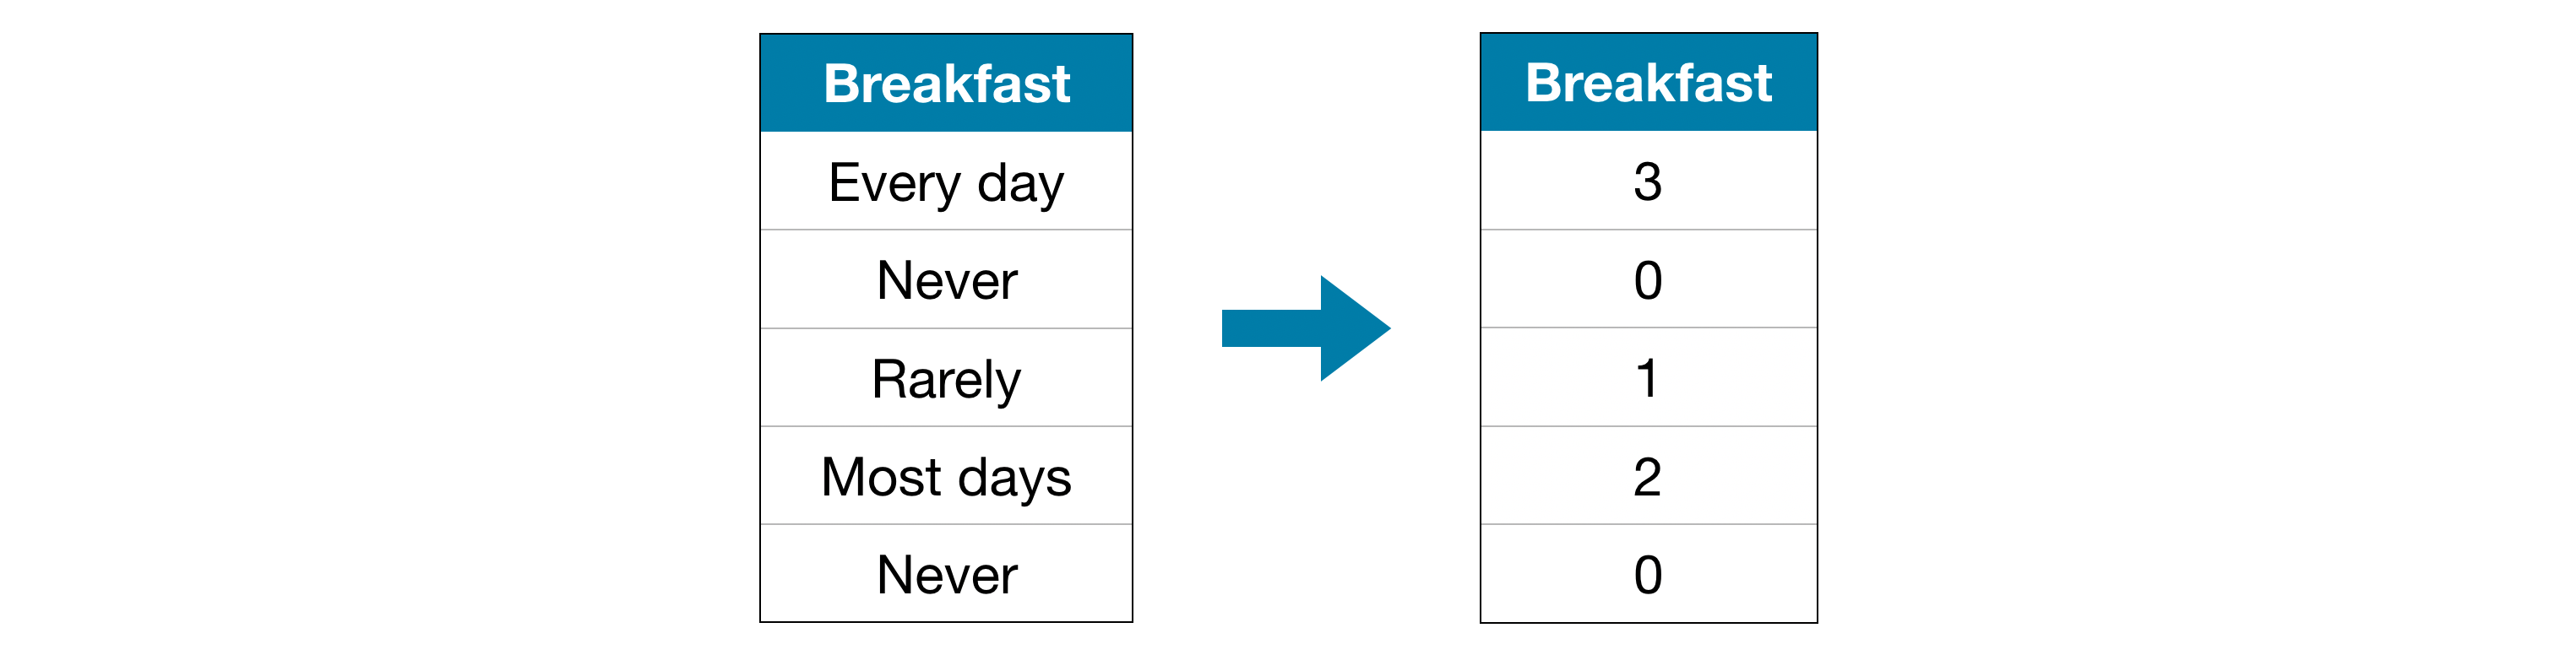

Questo approccio presuppone un ordine delle categorie: "Mai" (0) < "Raramente" (1) < "La maggior parte dei giorni" (2) < "Ogni giorno" (3).

Questa ipotesi ha senso in questo esempio, perché le categorie hanno un ordine indiscutibile. Non tutte le variabili categoriali hanno un ordine chiaro nei valori, ma ci riferiamo a quelle che lo hanno come variabili ordinali. Per i modelli ad albero (come gli alberi decisionali e le foreste casuali), la codifica ordinale funziona bene con le variabili ordinali.

3. **Codifica one-hot**  
La codifica one-hot crea nuove colonne che indicano la presenza (o l'assenza) di ogni possibile valore nei dati originali. Per comprenderla, facciamo un esempio.
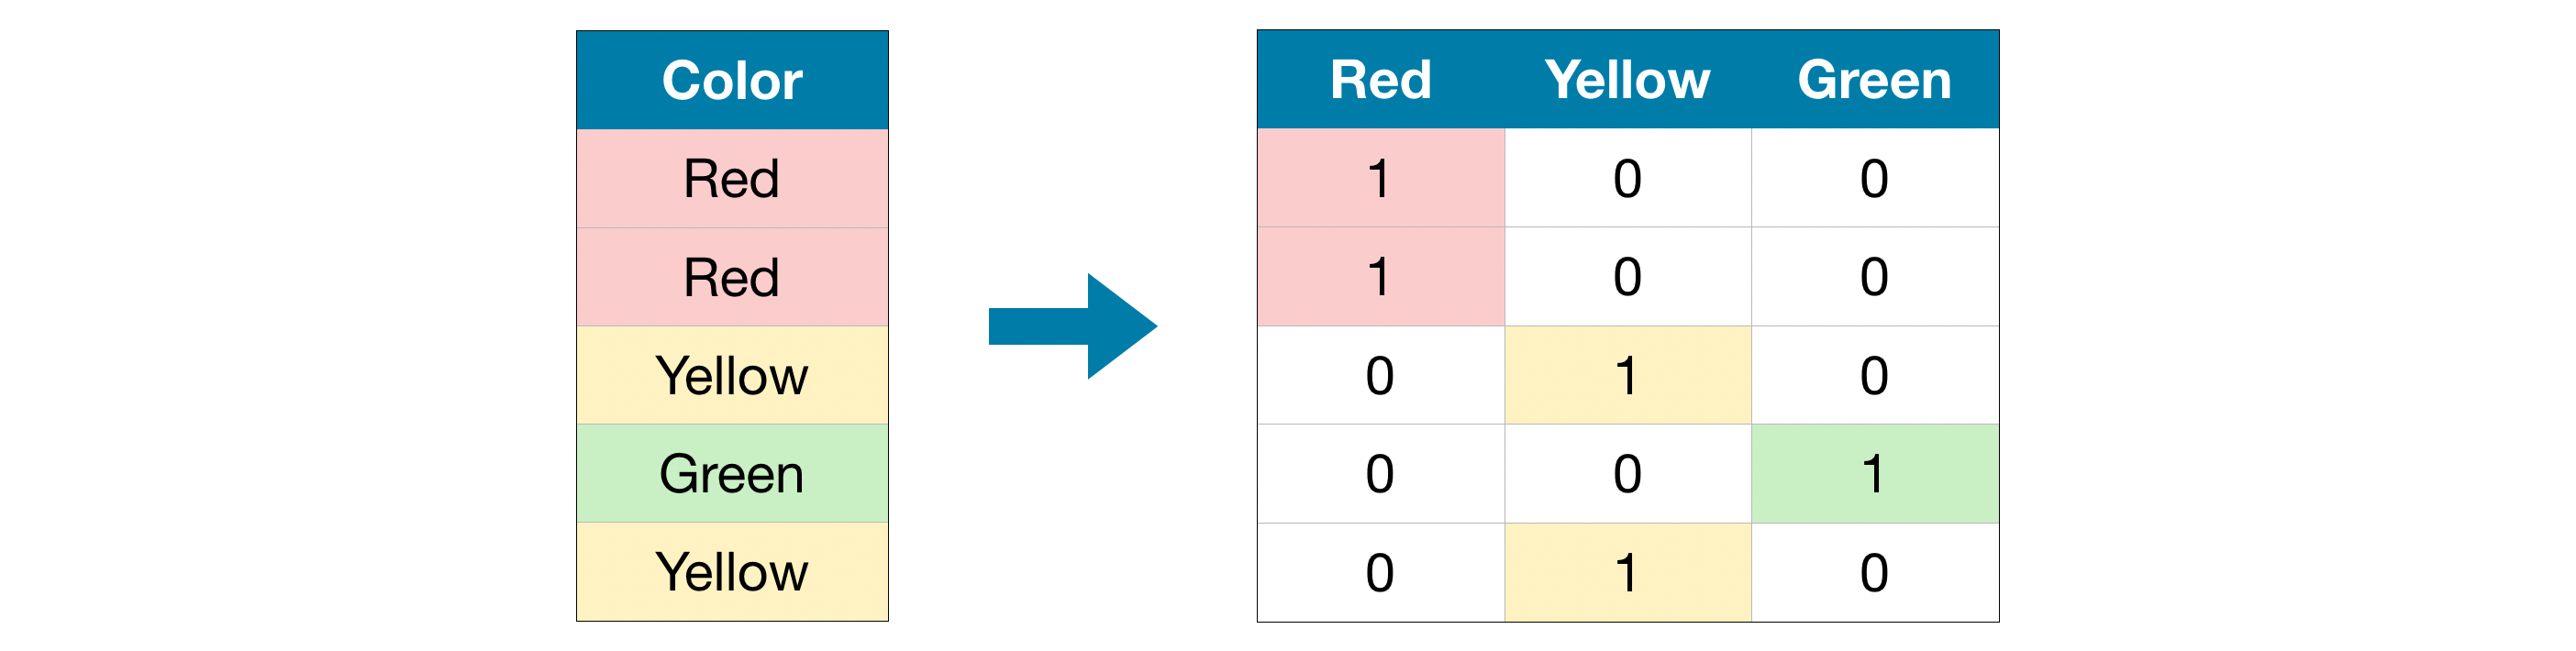

Nel dataset originale, "Colore" è una variabile categorica con tre categorie: "Rosso", "Giallo" e "Verde". La codifica one-hot corrispondente contiene una colonna per ogni possibile valore e una riga per ogni riga del dataset originale. Se il valore originale era "Rosso", mettiamo un 1 nella colonna "Rosso"; se il valore originale era "Giallo", mettiamo un 1 nella colonna "Giallo", e così via.

A differenza della codifica ordinale, la **codifica a un punto** non presuppone un ordine delle categorie. Pertanto, ci si può aspettare che questo approccio funzioni particolarmente bene se non esiste un ordine chiaro nei dati categoriali (ad esempio, "Rosso" non è né più né meno di "Giallo"). Le **variabili categoriali** prive di un ordine intrinseco sono definite variabili nominali.

La **codifica one-hot** in genere non funziona bene se la variabile categorica assume un numero elevato di valori (ad esempio, in genere non si usa per variabili che assumono più di 15 valori diversi).

### Esempio
Come nel tutorial precedente, lavoreremo con il dataset Melbourne Housing.

Non ci concentreremo sulla fase di caricamento dei dati. Si può invece immaginare di trovarsi a un punto in cui si hanno già i dati di addestramento e di validazione in `X_train`, `X_valid`, `y_train` e `y_valid`.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

Diamo un'occhiata ai dati di allenamento con il metodo `head()`.

In [2]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


Successivamente, si ottiene un elenco di tutte le variabili categoriali presenti nei dati di addestramento.

Per farlo, controlliamo il tipo di dati (o **dtype**) di ogni colonna. Il tipo di oggetto dtype indica che una colonna ha un testo (in teoria potrebbe essere anche altro, ma non è importante per i nostri scopi). Per questo set di dati, le colonne con testo indicano variabili categoriche.

In [3]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


**Definire una funzione per misurare la qualità di ciascun approccio**  
Abbiamo definito una funzione `score_dataset()` per confrontare i tre diversi approcci al trattamento delle variabili categoriche. Questa funzione riporta l'errore assoluto medio (MAE) di un modello random forest. In generale, vogliamo che il MAE sia il più basso possibile!

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

**Punteggio dell'approccio 1 (Eliminazione delle variabili categoriali)**  
Eliminiamo le colonne degli oggetti con il metodo `select_dtypes()`.

In [5]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175703.48185157913


**Punteggio dell'approccio 2 (codifica ordinale)**  
`Scikit-learn` dispone di una classe `OrdinalEncoder` che può essere utilizzata per ottenere codifiche ordinali. Eseguiamo un ciclo sulle variabili categoriali e applichiamo il codificatore ordinale separatamente a ogni colonna.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
165936.40548390493


Nella cella di codice qui sopra, per ogni colonna assegniamo casualmente ogni valore unico a un numero intero diverso. Si tratta di un approccio comune, più semplice rispetto alla fornitura di etichette personalizzate; tuttavia, possiamo aspettarci un ulteriore aumento delle prestazioni se forniamo etichette meglio informate per tutte le variabili ordinali.

**Punteggio dell'approccio 3 (codifica One-Hot)**  
Utilizziamo la classe `OneHotEncoder` di `scikit-learn` per ottenere codifiche one-hot. Esiste una serie di parametri che possono essere utilizzati per personalizzare il suo comportamento.

- Impostiamo handle_unknown='ignore' per evitare errori quando i dati di validazione contengono classi che non sono rappresentate nei dati di addestramento
- l'impostazione `sparse=False` assicura che le colonne codificate siano restituite come array numpy (invece che come matrice rada).

Per utilizzare il codificatore, è necessario fornire solo le colonne categoriali che si desidera codificare in modo univoco. Ad esempio, per codificare i dati di allenamento, si fornisce `X_train[object_cols]`. (`object_cols` nella cella di codice sottostante è un elenco di nomi di colonne con dati categoriali, quindi `X_train[object_cols]` contiene tutti i dati categoriali dell'insieme di allenamento).

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):


E:\Users\Alessio\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


166089.4893009678


E:\Users\Alessio\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In questo caso, l'eliminazione delle colonne categoriche (approccio 1) ha dato i risultati peggiori, poiché ha ottenuto il punteggio MAE più alto. Per quanto riguarda gli altri due approcci, poiché i punteggi MAE restituiti sono così vicini, non sembra esserci alcun vantaggio significativo per uno rispetto all'altro.

In generale, la codifica a un solo punto (**approccio 3**) è in genere la migliore e l'eliminazione delle colonne categoriche (approccio 1) è in genere la peggiore, ma varia a seconda dei casi.

## Esercizi
Le domande che seguono vi daranno un feedback sul vostro lavoro. Eseguite la seguente cella per impostare il sistema di feedback.

In [8]:
# Set up code checking
import os
if not os.path.exists("D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/train.csv"):
    os.symlink("D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/train.csv")  
    os.symlink("D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex3 import *
print("Setup Complete")

Setup Complete


Eseguire la cella di codice successiva senza modifiche per caricare i set di addestramento e di validazione in `X_train`, `X_valid`, `y_train` e `y_valid`. Il set di test viene caricato in `X_test`.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/train.csv', index_col='Id') 
X_test = pd.read_csv('D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

Utilizzare la cella di codice successiva per stampare le prime cinque righe dei dati.

In [10]:
X_train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,108,0,0,260,0,0,7,2007,New,Partial
871,20,RL,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2009,WD,Normal
93,30,RL,13360,Pave,IR1,HLS,AllPub,Inside,Gtl,Crawfor,...,0,44,0,0,0,0,8,2009,WD,Normal
818,20,RL,13265,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,59,0,0,0,0,0,7,2008,WD,Normal
303,20,RL,13704,Pave,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,...,81,0,0,0,0,0,1,2006,WD,Normal


Si noti che il set di dati contiene sia variabili numeriche che categoriche. Sarà necessario **codificare i dati categorici** prima di addestrare un modello.

Per confrontare diversi modelli, si utilizzerà la stessa funzione `score_dataset()` del tutorial. Questa funzione riporta l'errore assoluto medio (MAE) di un modello random forest.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Domanda 1
**Eliminare le colonne con dati categorici**

Si inizia con l'approccio più semplice.  Utilizzare la cella di codice sottostante per preelaborare i dati in `X_train` e `X_valid` per rimuovere le colonne con dati categorici.  Impostare i DataFrames preprocessati rispettivamente su `drop_X_train` e `drop_X_valid`. 

In [12]:
# Drop columns in training and validation data
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

# Check your answers
step_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Eseguire la cella di codice successiva per ottenere il MAE di questo approccio.

In [13]:
print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
17837.82570776256


Prima di passare alla codifica ordinale, analizzeremo il set di dati. In particolare, esamineremo la colonna 'Condition2'. La cella di codice sottostante stampa le voci univoche in entrambi gli insiemi di allenamento e di validazione.

In [15]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


### Domanda 2
**Codifica ordinale**

Se ora si scrive del codice per: 
- adattare un codificatore ordinale ai dati di addestramento
- utilizzare per trasformare sia i dati di addestramento che quelli di validazione, 

si otterrà un errore.  Riuscite a capire il perché di questo errore?  (_Per rispondere a questa domanda è necessario utilizzare l'output di cui sopra)_.

In [16]:
# Check your answer (Run this code cell to receive credit!)
step_2.a.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Fitting an ordinal encoder to a column in the training data creates a corresponding integer-valued label for each unique value **that appears in the training data**. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them.  Notice that the `'Condition2'` column in the validation data contains the values `'RRAn'` and `'RRNn'`, but these don't appear in the training data -- thus, if we try to use an ordinal encoder with scikit-learn, the code will throw an error.

Questo è un problema comune che si incontra con i dati del mondo reale e ci sono molti approcci per risolverlo.  Ad esempio, si può scrivere un codificatore ordinale personalizzato per gestire le nuove categorie.  L'approccio più semplice, tuttavia, consiste nell'eliminare le colonne categoriali problematiche.  

Eseguire la cella di codice sottostante per salvare le colonne problematiche in un elenco Python `bad_label_cols`.  Allo stesso modo, le colonne che possono essere codificate in modo ordinale in modo sicuro sono memorizzate in `good_label_cols`.

In [17]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['RoofMatl', 'Functional', 'Condition2']


Utilizzare la cella di codice successiva per codificare ordinalmente i dati in `X_train` e `X_valid`.  Impostare i DataFrames pre-elaborati rispettivamente su `label_X_train` e `label_X_valid`.  
- Di seguito è riportato il codice per eliminare le colonne categoriche in `bad_label_cols` dal set di dati. 
- È necessario codificare ordinalmente le colonne categoriche in `good_label_cols`.  

In [18]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder
ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(X_valid[good_label_cols])
    
# Check your answer
step_2.b.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Eseguire la cella di codice successiva per ottenere il MAE di questo approccio.

In [19]:
print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
17098.01649543379


Finora si sono provati due approcci diversi per gestire le variabili categoriche. Si è visto che la codifica dei dati categoriali dà risultati migliori rispetto alla rimozione delle colonne dal set di dati.

Presto proverete la **codifica one-hot**. Prima di allora, è necessario affrontare un altro argomento. Iniziate eseguendo la prossima cella di codice senza modifiche.

In [20]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

### Domanda 3
**Indagine sulla cardinalità**

L'output qui sopra mostra, per ogni colonna con dati categorici, il numero di valori unici nella colonna.  Per esempio, la colonna `'Street'` nei dati di addestramento ha due valori unici: `'Grvl'` e `'Pave'`, che corrispondono rispettivamente a una strada di ghiaia e a una strada asfaltata.

Il numero di voci uniche di una variabile categorica viene definito **cardinalità** di quella variabile categorica.  Ad esempio, la variabile `'Street'` ha cardinalità 2.

Utilizzate l'output di cui sopra per rispondere alle domande seguenti.

In [21]:
# How many categorical variables in the training data
# have cardinality greater than 10?
high_cardinality_numcols = 3

# How many columns are needed to one-hot encode the
# 'Neighborhood' variable in the training data?
num_cols_neighborhood = 25

# Check your answers
step_3.a.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Per i dataset di grandi dimensioni con molte righe, la **codifica one-hot** può espandere notevolmente le dimensioni del dataset.  Per questo motivo, di solito si codificano solo le colonne con cardinalità relativamente bassa.  Quindi, le colonne ad alta cardinalità possono essere eliminate dal set di dati, oppure si può utilizzare la codifica ordinale.

A titolo di esempio, si consideri un set di dati con 10.000 righe e contenente una colonna categorica con 100 voci uniche.  
- Se questa colonna viene sostituita con la corrispondente codifica a un punto, quante voci vengono aggiunte al set di dati?  
- Se invece sostituiamo la colonna con la codifica ordinale, quante voci vengono aggiunte?  

Utilizzate le vostre risposte per riempire le righe sottostanti.

In [22]:
# How many entries are added to the dataset by
# replacing the column with a one-hot encoding?
OH_entries_added = 1e4*100 - 1e4

# How many entries are added to the dataset by
# replacing the column with an ordinal encoding?
label_entries_added = 0

# Check your answers
step_3.b.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Successivamente, si sperimenterà la codifica one-hot.  Ma, invece di codificare tutte le variabili categoriali del set di dati, si creerà una codifica one-hot solo per le colonne con cardinalità inferiore a 10.

Eseguire la cella di codice qui sotto, senza modifiche, per impostare `low_cardinality_cols` su un elenco Python contenente le colonne che saranno codificate con un solo colpo.  Allo stesso modo, `high_cardinality_cols` contiene un elenco di colonne categoriche che saranno eliminate dal dataset.

In [23]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Exterior2nd', 'Neighborhood']


# Domanda 4
**Codifica one-hot**

Utilizzare la cella di codice successiva per codificare a caldo i dati in `X_train` e `X_valid`.  Impostare i DataFrames preprocessati rispettivamente su `OH_X_train` e `OH_X_valid`.  
- L'elenco completo delle colonne categoriali del set di dati si trova nell'elenco Python `object_cols`.
- È necessario codificare solo le colonne categoriche in `low_cardinality_cols`.  Tutte le altre colonne categoriche devono essere eliminate dal set di dati. 

In [24]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Check your answer
step_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Eseguire la cella di codice successiva per ottenere il MAE di questo approccio.

In [25]:
print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):


E:\Users\Alessio\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


17525.345719178084


E:\Users\Alessio\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
